# 오토인코더로 이미지의 특징을 추출하기

In [101]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import torch.nn.init as init # 초기화 관련 모듈 

In [102]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 16
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [113]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root      = './data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)
testset = datasets.FashionMNIST(
    root      = './data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = 2
)

len(trainset),len(testset)


(60000, 10000)

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

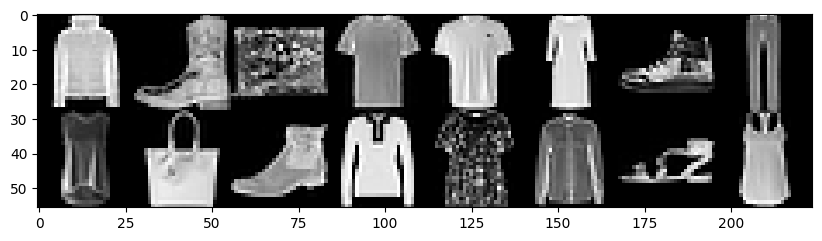

In [104]:
dataiter       = iter(train_loader) #배치 1개만 뽑아 데이터가 생긴 형태를 살펴보겠습니다
images, labels = next(dataiter)

# 여러 이미지 모아보기
img   = utils.make_grid(images, padding=0) # util.make_grid() 함수를 이용해 여러 이미지를 하나로 모아 하나의 이미지로 만듭니다
npimg = img.numpy() # img는 파이토치 텐서입니다. numpy()함수로 맷플롯립과 호환이 되는 넘파이 행렬로 바꿔줍니다.
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0))) #np.transpose() 함수를 이용해 첫 번째(0번째) 차원을 맨 뒤로 보냅니다
plt.show()
# 여러 개의 패션 아이템이 흑백으로 나열되는 것을 볼 수 있습니다

In [105]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(28*28, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 12),
#             nn.ReLU(),
#             nn.Linear(12, 3),   # 입력의 특징을 3차원으로 압축합니다
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(3, 12),
#             nn.ReLU(),
#             nn.Linear(12, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 28*28),
#             nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded

In [106]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 144),
            nn.ReLU(),
            nn.Linear(144, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 3),   # 입력의 특징을 3차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 144),
            nn.ReLU(),
            nn.Linear(144, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [107]:
class Descriminator(nn.Module):
    def __init__(self) -> None:
        super(Descriminator,self).__init__()
        self.des = nn.Sequential(
            nn.Linear(28*28,124),
            nn.ReLU(),
            nn.Linear(124,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,2)
        )
    def forward(self,x):
        x = self.des(x)
        return x

In [108]:
autoencoder = Autoencoder().to(DEVICE) # 정의한 모델을 GPU로 납치
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)


autoencoder.apply(weight_init)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [109]:
# 원본 이미지를 시각화 하기 (첫번째 열)
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [110]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 1]


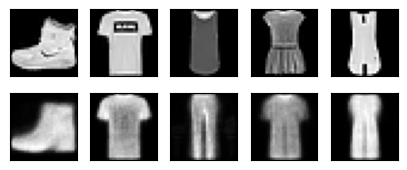

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 2]


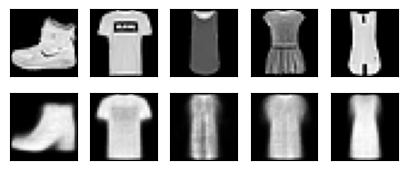

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 3]


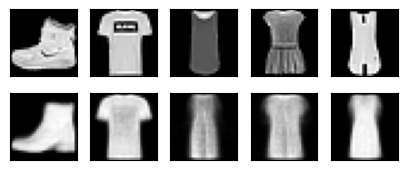

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 4]


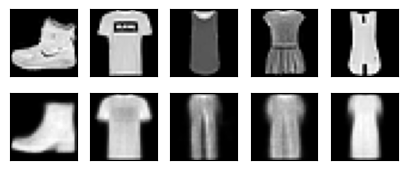

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 5]


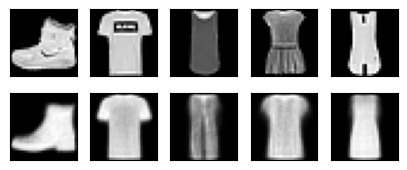

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 6]


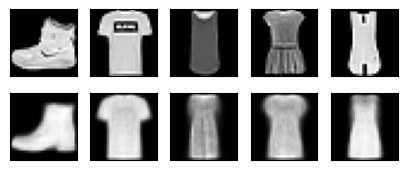

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 7]


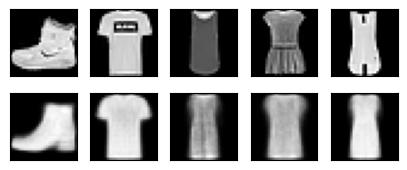

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 8]


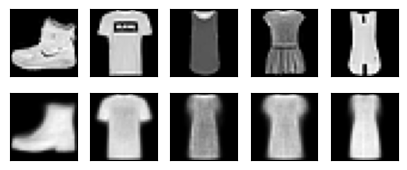

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 9]


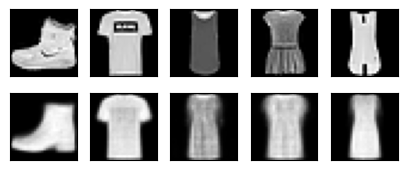

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

[Epoch 10]


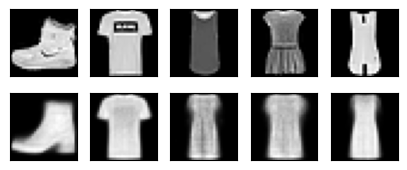

In [59]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    # 디코더에서 나온 이미지를 시각화 하기 (두번째 열)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [100]:
sampling_z = torch.randn(0)
for x,y in train_loader:
    print(x.shape)
    print(y.shape)
    x = x.view(-1,784).to(DEVICE)
    z, decoded = autoencoder(x)
    sampling_z = torch.concat((sampling_z,z),dim=0)

/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <870081F6-12FD-3CEA-BC5C-30F4764F2A98> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/juniverse/opt/anaconda3/envs/veda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed 

torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size([16, 1, 28, 28])
torch.Size([16])
torch.Size

In [122]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            image = image.view(-1,784)
            _,output= autoencoder(image)
            # test_loss += loss(output, label).item()
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [124]:
# for Epoch in range(1, EPOCH + 1):
#     train(autoencoder, train_loader) #, optimizer, log_interval=100)
#     test_loss, test_accuracy = evaluate(autoencoder, test_loader)
#     print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %".format(
#         Epoch, test_loss, test_accuracy
#     ))

# 잠재변수 들여다보기

In [125]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

In [126]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    ax.set_zlim(Z.min(), Z.max())
    plt.show()

<Figure size 1000x800 with 0 Axes>

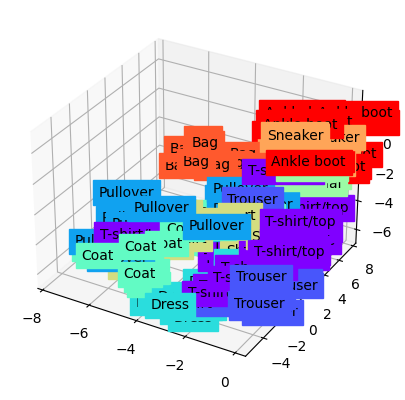

In [130]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
# 데이터 생성

# 클래스 이름과 색상 매핑
cm = plt.cm.rainbow

# 3D 플롯 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 데이터 포인트에 클래스 이름과 색상을 지정
for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)

# 축 범위 설정
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

# 플롯 표시
plt.show()


In [131]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 데이터 생성
X = np.arange(-10, 10, 0.1)
Y = np.arange(-10, 10, 0.1)
Z = np.zeros((len(X), len(Y)))
for i in range(len(X)):
    for j in range(len(Y)):
        Z[i, j] = np.sin(i * X) * np.cos(j * Y)

# 클래스 이름과 색상 매핑
cm = plt.cm.rainbow

# 3D 플롯 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 데이터 포인트에 클래스 이름과 색상을 지정
def update(frame):
    # 각 데이터 포인트의 위치를 ​​변경합니다.
    for i in range(len(X)):
        for j in range(len(Y)):
            Z[i, j] = np.sin(frame * i * X) * np.cos(frame * j * Y)

    # 플롯을 업데이트합니다.
    ax.clear()
    for x, y, z, s in zip(X, Y, Z, labels):
        name = CLASSES[s]
        color = cm(int(255 * s / 9))
        ax.text(x, y, z, name, backgroundcolor=color)

    # 축 범위를 설정합니다.
    ax.set_xlim(X.min(), X.max())
    ax.set_ylim(Y.min(), Y.max())
    ax.set_zlim(Z.min(), Z.max())

# 애니메이션을 생성합니다.
ani = animation.FuncAnimation(fig, update, interval=100)
plt.show()


ValueError: setting an array element with a sequence.

MovieWriter imagemagick unavailable; using Pillow instead.


Making animation


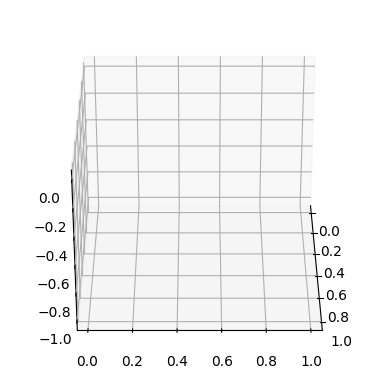

In [44]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation


raw = np.random.rand(100,3)
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
x = raw[:, 0]
y = raw[:, 1]
z = raw[:, 2]

ax.scatter(x, y, -z, zdir='z', c='black', depthshade=False, s=0.2, marker=',')

def rotate(angle):
    ax.view_init(azim=angle)

print("Making animation")
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
rot_animation.save('rotation.gif', dpi=80, writer='imagemagick')